In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import stats
from scipy.optimize import curve_fit, least_squares
from scipy.interpolate import interp1d
import pandas as pd
import csv
import os
from dl import queryClient as qc
from astropy.table import Table
import utils

C:\Users\kylem\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kylem\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\kylem\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
pltdir = 'results/plots'
if not os.path.exists(pltdir):
    os.makedirs(pltdir)

In [3]:
os.getcwd()

'D:\\msu\\DavidNidever\\TempletFit'

In [4]:
# interesting = np.loadtxt('goldsample\golden_original.txt',dtype=str)

In [5]:
gldorig = np.loadtxt('goldsample\golden_original.txt',delimiter=',',dtype=str)
gldrrab = np.loadtxt('goldsample\golden_RRab.txt',delimiter=',',dtype=str)
gldall  = np.union1d(gldorig,gldrrab)
gldelse = list(set(gldall) - set(gldrrab))

In [6]:
def get_data(objname, bands = ['u','g','r','i','z']):
    """Query the object by name, extract light curves, estimated period and filters."""
    df=qc.query(sql="""SELECT meas.* 
                     FROM nsc_dr2.meas
                     WHERE objectid='{:s}'""".format(objname),
              fmt='pandas')
    crv=[]
    best_periods = []
    fltrs=[]
    initpars = []
    for f in bands:
        selfltr = (df['filter'] == f)
        selfwhm = (df['fwhm'] <= 4.0)
        sel = selfltr & selfwhm
        if sum(sel) < 25:
            continue
        t = df['mjd'][sel].values
        y = df['mag_auto'][sel].values
        dy = df['magerr_auto'][sel].values
        
        # get estimated period
        pout = get_ls_period(t,y,objname=objname+'_'+f,outdir='results\plots')
        best_periods.append(pout)
        # save light curve data and initialize parameter estimate
        crvi = np.vstack((t,y,dy)).T
        crv.append(crvi[np.argsort(crvi[:,0])])
        initpars.append([0.0,max(y)-min(y),min(y)])
        # record which filter was used
        fltrs.append(f)
    
    # Find mean period and return results
    period = np.mean(best_periods)
    return crv, period, fltrs, np.array(initpars)

def get_ls_period(t,y,min_freq=1./1.,max_freq=1./0.1,objname='',outdir='results/plots'):
    """Use Lomb-Scargle periodogram to get an estimate on period"""
    
    pmin = .1
    pmax = 10
    min_freq=1./pmax
    max_freq=1./pmin
    
    ls = stats.LombScargle(t, y)
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq)
    period = 1./frequency # period is the inverse of frequency
    
    best_period = period[np.argmax(power)]
    
    plot_periodogram(period,power,best_period,objname=objname,outdir=outdir)
    return best_period

def plot_periodogram(period,power,best_period=None,objname='',ax=None,outdir='results/plots'):
   
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
        
    ax.plot(period,power,lw=0.1)
    ax.set_xlabel('period (days)')
    ax.set_ylabel('relative power')
    ax.set_title(objname)
    
    if best_period is not None:
        ax.axvline(best_period,ms=.1,color='r');
        ax.text(0.03,0.93,'period = {:.3f} days'.format(best_period),transform=ax.transAxes,color='r')
    fig.savefig(outdir+'\\{}_periodogram.png'.format(objname))
    plt.close(fig)
    return

def RemoveOutliers(crv,tmps,pars,period,Ns):
    crv_in = []
    for i in range(len(crv)):
        fn = interp1d(tmps[i][:,0],tmps[i][:,Ns[i]]*pars[i,1]+pars[i,2])
        phase = (crv[i][:,0]/period-pars[i,0]) %1
        dif = abs(crv[i][:,1]-fn(phase))
        crv_in.append(crv[i][dif<utils.mad(dif)*5])
    return crv_in

In [7]:
# n=0
# display(interesting[n])
crv,p,flts,initpars = get_data('192654_190153')

In [8]:
pmin = 0.02
pmax = 1000
min_freq=1./pmax
max_freq=1./pmin
i=0
t = crv[i][:,0]
y = crv[i][:,1]

ls = stats.LombScargle(t, y)
frequency, power = ls.autopower(samples_per_peak=3,minimum_frequency=min_freq,maximum_frequency=max_freq)
period = 1./frequency # period is the inverse of frequency

best_period = period[np.argmax(power)]

array([7.83958708, 5.28979396, 3.65972851, 2.92188556, 2.34872666,
       2.04946874, 1.69767503, 1.53560391, 1.39510063, 1.30058277,
       1.19008285, 0.83063633, 0.78995542, 0.73947238, 0.69970561,
       0.67509892, 0.64647552, 0.62561446, 0.60593221, 0.56423985,
       0.53330107, 0.46710034, 0.44767184, 0.43747   , 0.42644551,
       0.41177965, 0.40152882, 0.38647466, 0.37539844, 0.29138436])

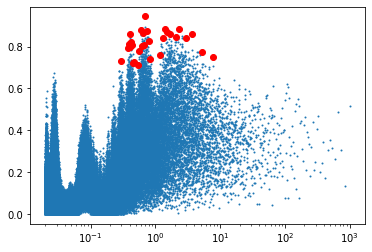

In [9]:
from scipy.signal import find_peaks
height = max(power)*.75
dist   = 1/np.mean(period[:-1]-period[1:])
inds   = find_peaks(power,height=height,distance=dist)[0]

plt.scatter(period,power,s=1)
plt.scatter(period[inds],power[inds],c='r')
plt.xscale('log')
# plt.xlim(.45,.46)
period[inds]

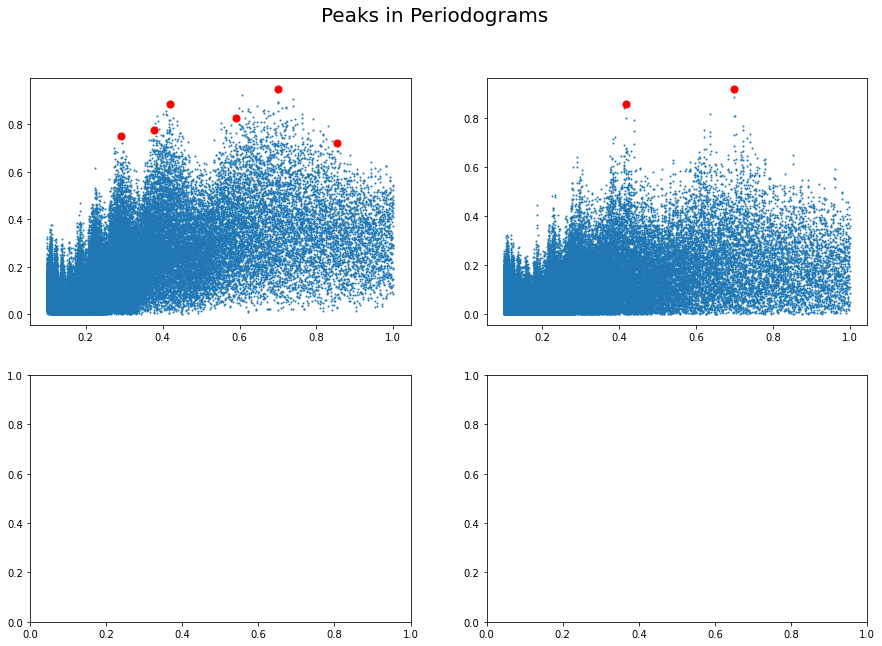

In [10]:
from scipy.signal import find_peaks
fig, ax = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Peaks in Periodograms',fontsize=20)
plist = []
for f in range(len(crv)):
    ls = stats.LombScargle(crv[f][:,0],crv[f][:,1])
    frequency, power = ls.autopower(minimum_frequency=1/1.,maximum_frequency=1/.1)
    period = 1./frequency # period is the inverse of frequency


    height = max(power)*.75
    dist   = .025/np.mean(period[:-1]-period[1:])
    inds   = find_peaks(power,height=height,distance=dist)[0]
    plist.append(period[inds])
    ax[int(f/2),f%2].scatter(period,power,s=1)
    ax[int(f/2),f%2].scatter(period[inds],power[inds],s=50,c='r')

In [11]:
class tmpfitter:
    def __init__ (self, tmps, allfs= ['u','g','r','i','z']):
        self.tmps  = tmps
        self.allfs = allfs # list of filters of all templates
        self.f     = 0 # index of filter
        self.n     = 1 # index of template

    def model(self, t, t0, amplitude, yoffset):
        """modify the template using peak-to-peak amplitude and yoffset
        input times t should be epoch folded, phase shift to match template"""
        xtemp = self.tmps[self.f][:,0]
        ytemp = self.tmps[self.f][:,self.n]*amplitude + yoffset
        ph = (t - t0) %1
        # interpolate the modified template to the phase we want
        return interp1d(xtemp,ytemp)(ph)

    def tmpfit(self,crv,p,fltrs,initpars,w=.1,steps=21):
        plist = np.linspace(p-w,p+w,steps)
        minsumx2 = 2**99
        besttmps = np.zeros(len(fltrs),dtype='int8')
        bestpars = np.zeros((len(fltrs),3))
        bestperr = np.zeros((len(fltrs),3))
        bestp    = 0
        for p in plist:
            sumx2 = 0
            bestn = np.zeros(len(fltrs),dtype='int8')
            ppars = np.zeros((len(fltrs),3))
            pperr = np.zeros((len(fltrs),3))
            for fi,ft in enumerate([self.allfs.index(j) for j in fltrs]):
                self.f = ft
                phase = crv[fi][:,0] /p %1 #converts dates to a phase between 0 and 1
                                
                minx2 = 2**99
                for n in range(1,len(self.tmps[ft][0])):
                    self.n = n
                    try:
                        pars, cov = curve_fit(self.model, phase, crv[fi][:,1], 
                                              bounds = ((-.5,0,-50),(.5,10,50)),
                                              sigma=crv[fi][:,2], p0=initpars[fi])
                    except RuntimeError:
                        #print('error')
                        continue
                    
                    x2 = sum((self.model(phase,pars[0],pars[1],pars[2])-crv[fi][:,1])**2/crv[fi][:,2]**2)
                    if x2 < minx2:
                        minx2 = x2
                        bestn[fi] = n
                        ppars[fi] = pars
                        pperr[fi] = np.sqrt(np.diag(cov))
                sumx2 += minx2
                if sumx2 > minsumx2:
                    break
            if sumx2 < minsumx2:
                minsumx2 = sumx2
                besttmps = bestn
                bestpars = ppars
                bestperr = pperr
                bestp    = p
        Npnts = 0
        for j in range(len(crv)):
            Npnts += len(crv[j])
        return bestpars, bestperr, bestp, besttmps, minsumx2, minsumx2/(Npnts-3) #reduced chi square

In [12]:
with open("templates/LaydenTemplates.txt") as myfile:
    head = [next(myfile) for x in range(2)]
tmpcols = head[0].replace(' ','').replace('\n','').split(',')
tmptyps = head[1].replace(' ','').replace('\n','').split(',')

tmps = np.genfromtxt("templates/LaydenTemplates.txt",delimiter=',',skip_header=2)
tmps = [tmps]*5
fitter = tmpfitter(tmps,['u','g','r','i','z'])
def fit_plot(objname):
    crv, p ,fltrs, initpars = get_data(objname)
    print(p)
    if len(fltrs) == 0:
        return
    pars,perr,p,Ns,chi2,redchi = fitter.tmpfit(crv,p,fltrs,initpars,w=.15,steps=31)
    print(p)
    crv_in = RemoveOutliers(crv,tmps,pars,p,Ns)
    pars,perr,p,Ns,chi2,redchi = fitter.tmpfit(crv_in,p,fltrs,pars,w=.01,steps=11)
    print(p)
    
    # double crv and tmps
    crv2 = []
    tmp2 = []
    for i in range(len(crv)):
        crv2.append(crv[i].copy())
        crv2[i][:,0] = (crv2[i][:,0]/p-pars[i,0])%1
        crv2[i] = crv2[i][crv2[i][:,0].argsort()]
        crv2[i] = np.tile(crv2[i].T,2).T
        crv2[i][int(len(crv2[i])/2):,0] += 1
        
        tmp2.append(np.tile(tmps[i].T,2).T)
        tmp2[i][int(len(tmp2[i])/2):,0] += 1
    #---#
    
    fig, ax = plt.subplots(len(fltrs), figsize=(10,10), sharex=True)
    if len(fltrs) == 1:
        ax = [ax]
    colors = ['b','g','r','y','k']
    
    for i in range(len(fltrs)):
        ax[i].scatter(crv2[i][:,0],crv2[i][:,1],c=colors[i])
        ax[i].plot(tmp2[i][:,0],tmp2[i][:,Ns[i]]*pars[i,1]+pars[i,2],c='black')
        ax[i].invert_yaxis()
        ax[i].set_ylabel(fltrs[i], fontsize=18)

    ax[-1].set_xlabel('Phase', fontsize=16)
    ax[0].set_title("Object: {}    Period: {:.3f} d    Type: {}".format(objname,p,'typ'), fontsize=20)
    fig.savefig('results/plots/{}.png'.format(objname))
    
    file = open('results/{}_parameters.csv'.format(objname),'w')
    file.write("{},{:.3f},{:.3f},{:.3f}\n".format(objname,p,chi2,redchi))
    for i in range(len(fltrs)):
        file.write("{},{:.3f},{:.3f},{:.3f},".format(fltrs[i],pars[i,0],pars[i,1],pars[i,2]))
        file.write("{:.6f},{:.6f},{:.6f},{},{}\n".format(perr[i,0],perr[i,1],perr[i,2],tmpcols[Ns[i]],len(crv_in[i])))
    plt.close(fig)

In [13]:
fit_plot('95302_16871')

0.4123343999702452
0.5623343999702451
0.5623343999702451


In [14]:
for nm in gldall:
    break
    print(nm,end=',')
    #fit_plot(nm)

In [15]:
crvs,p,fltrs,initpars = get_data('149139_114961')

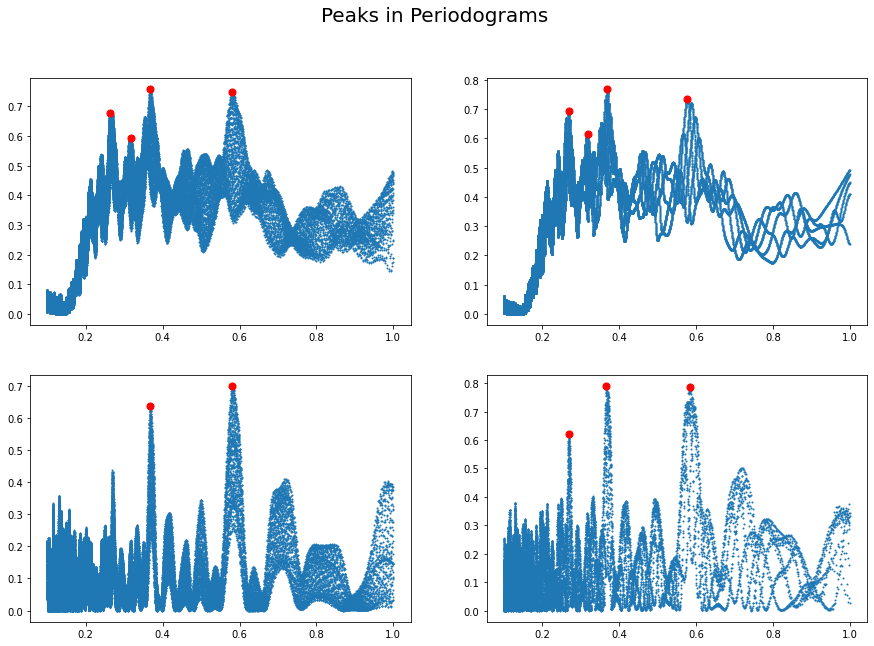

In [16]:
from scipy.signal import find_peaks
fig, ax = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Peaks in Periodograms',fontsize=20)
plist = []
for f in range(len(crvs)):
    ls = stats.LombScargle(crvs[f][:,0],crvs[f][:,1])
    frequency, power = ls.autopower(minimum_frequency=1/1.,maximum_frequency=1/.1)
    period = 1./frequency # period is the inverse of frequency


    height = max(power)*.75
    dist   = .025/np.mean(period[:-1]-period[1:])
    inds   = find_peaks(power,height=height,distance=dist)[0]
    plist.append(period[inds])
    ax[int(f/2),f%2].scatter(period,power,s=1)
    ax[int(f/2),f%2].scatter(period[inds],power[inds],s=50,c='r')

In [17]:
plist

[array([0.58085228, 0.36698144, 0.31786087, 0.26215751]),
 array([0.57753446, 0.3685568 , 0.318097  , 0.26880812]),
 array([0.58091726, 0.36823691]),
 array([0.58453931, 0.36634454, 0.2695731 ])]

In [18]:
(0.36698144 + 0.3685568 + 0.36823691 + 0.36634454)/4

0.3675299225

In [19]:
(0.58085228 + 0.57753446 + 0.58091726 + 0.58453931)/4

0.5809608275

In [20]:
with open("templates/LaydenTemplates.txt") as myfile:
    head = [next(myfile) for x in range(2)]
tmpcols = head[0].replace(' ','').replace('\n','').split(',')
tmptyps = head[1].replace(' ','').replace('\n','').split(',')

In [21]:
from astropy.table import Table

tabl = Table.read('p_amp_upsilon.fits',format='fits')

In [22]:
inds = [j for j,nm in enumerate(tabl['id']) if nm in gldrrab]
usel = tabl['uamp'] != -99.99
print(sum(usel[inds]))
gsel = tabl['gamp'] != -99.99
print(sum(gsel[inds]))
rsel = tabl['ramp'] != -99.99
print(sum(rsel[inds]))
isel = tabl['iamp'] != -99.99
print(sum(isel[inds]))
zsel = tabl['zamp'] != -99.99
print(sum(zsel[inds]))

59
584
569
433
309


1.6500994581527708
0.5064791050650946
1.6476377952755905


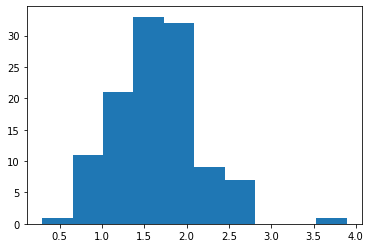

In [23]:
sel = usel*rsel
ratios = (tabl['uamp'][sel]/tabl['ramp'][sel])
plt.hist(ratios)
print(np.mean(ratios))
print(np.std(ratios))
print(np.median(ratios))

In [24]:
from collections import Counter
Counter(tabl['type'])

Counter({'RRL_ab': 650,
         'EB_ED': 21,
         'CEPH_Other': 46,
         'EB_EC': 234,
         'DSCT': 90,
         'RRL_c': 122,
         'T2CEPH': 55,
         'NonVar': 4,
         'EB_ESD': 61,
         'CEPH_F': 40,
         'LPV_Mira_A': 1,
         'CEPH_1O': 36,
         'RRL_d': 2,
         'RRL_e': 4,
         'LPV_SRV_AG': 1})

In [25]:
def find_matching_index(list1, list2):

    inverse_index = { element: index for index, element in enumerate(list1) }

    return [index for index, element in enumerate(list2) if element in inverse_index]

In [26]:
indsall = find_matching_index(gldall,tabl['id'])
indsrrab = find_matching_index(gldrrab,tabl['id'])
indselse = find_matching_index(gldelse,tabl['id'])

In [27]:
indsab  = np.argwhere(tabl['type']=='RRL_ab')[:,0]
indsc   = np.argwhere(tabl['type']=='RRL_c')[:,0]
indseb  = np.argwhere(tabl['type']=='EB_EC')[:,0]
inddsct = np.argwhere(tabl['type']=='DSCT')[:,0]

indcephothr = np.argwhere(tabl['type']=='CEPH_Other')[:,0]
indcephT2 = np.argwhere(tabl['type']=='T2CEPH')[:,0]
indcephf = np.argwhere(tabl['type']=='CEPH_F')[:,0]
indceph1O = np.argwhere(tabl['type']=='CEPH_1O')[:,0]
indceph = np.union1d(np.union1d(indcephothr,indcephT2),np.union1d(indcephf,indceph1O))

(0.0, 1.0)

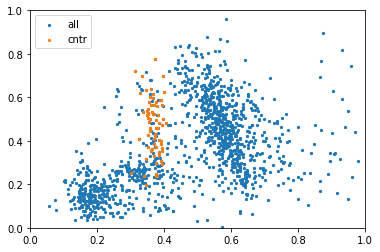

In [28]:
famp = 'gamp'
cntr = np.where((tabl['period']>.3)*(tabl['period']<.41)*(tabl['type']=='RRL_ab'))
plt.scatter(tabl[indsall]['period'],tabl[indsall][famp],s=5,label='all')
plt.scatter(tabl[cntr]['period'],tabl[cntr][famp],s=5,label='cntr')
# plt.scatter(.591,.75)
# plt.scatter(.36,.762)
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)

In [29]:
newperiods = np.array([6.65689638e-01, 4.63246407e-01, 4.86505162e-01, 5.98612662e-01,
       6.04680791e-01, 5.81281334e-01, 3.96118626e-01, 6.08425894e-01,
       5.68653577e-01, 6.09191501e-01, 6.31970740e-01, 4.48351623e-01,
       3.41665531e-01, 5.52363124e-01, 5.54615557e-01, 3.92686212e-01,
       5.39468682e-01, 5.55374307e-01, 3.78888756e-01, 5.14636736e-01,
       5.57525419e-01, 5.39280632e-01, 6.44125117e-01, 5.56710292e-01,
       5.31727495e-01, 5.85075155e-01, 3.48696834e-01, 5.88347039e-01,
       3.41066727e-01, 5.92682884e-01, 5.32668786e-01, 3.79859284e-01,
       6.81752148e-01, 6.03112521e-01, 6.67761484e-01, 5.59372185e-01,
       3.45432298e-01, 5.34241839e-01, 3.62958018e-01, 5.97820416e-01,
       5.28512962e-01, 5.36173691e-01, 5.70718082e-01, 5.98624724e-01,
       6.19660569e-01, 4.99789283e-01, 5.85201830e-01, 5.71617737e-01,
       5.95973321e-01, 6.23700186e-01, 5.93079373e-01, 5.87087210e-01,
       6.00908414e-01, 6.09510784e-01, 5.62334701e-01, 6.15223082e-01,
       6.22140568e-01, 5.31407051e-01, 5.61939316e-01, 3.72542606e-01,
       5.48696658e-01, 5.03606654e-01, 5.45534332e-01, 5.06603103e-01,
       5.85834019e-01, 5.87071424e-01, 5.83688300e-01, 5.79709230e-01,
       3.69591994e-01, 6.00872292e-01, 3.47776881e-01, 1.87006443e+02,
       6.65319712e-01, 9.81842988e+02, 5.71880377e-01])
oldperiods = np.array(tabl[cntr]['period'])

(0.0, 1.0)

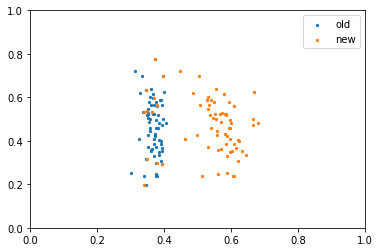

In [30]:
famp = 'gamp'
plt.scatter(oldperiods,tabl[cntr][famp],s=5,label='old')
plt.scatter(newperiods,tabl[cntr][famp],s=5,label='new')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)

In [31]:
import random
cntrnames = tabl['id'][cntr]
cntrnames[random.randint(0,74)]

'148622_51065'

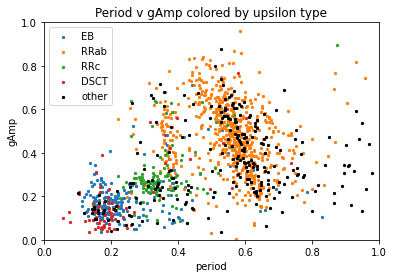

In [32]:
famp = 'gamp'
plt.scatter(tabl[indseb]['period'],tabl[indseb][famp],s=5,label='EB')
plt.scatter(tabl[indsab]['period'],tabl[indsab][famp],s=5,label='RRab')
plt.scatter(tabl[indsc]['period'],tabl[indsc][famp],s=5,label='RRc')
plt.scatter(tabl[inddsct]['period'],tabl[inddsct][famp],s=5,label='DSCT')
othr = list(set(range(len(tabl)))-set(indsab)-set(indsc)-set(indseb)-set(inddsct))
plt.scatter(tabl[othr]['period'],tabl[othr][famp],c='k',s=5,label='other')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Period v {}Amp colored by upsilon type'.format(famp[0]))
plt.xlabel('period')
plt.ylabel('{}Amp'.format(famp[0]))
plt.legend()

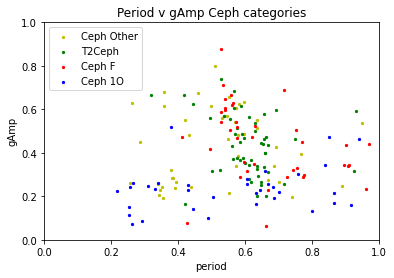

In [33]:
famp = 'gamp'
plt.scatter(tabl[indcephothr]['period'],tabl[indcephothr][famp],s=5,c='y',label='Ceph Other')
plt.scatter(tabl[indcephT2]['period'],tabl[indcephT2][famp],s=5,c='g',label='T2Ceph')
plt.scatter(tabl[indcephf]['period'],tabl[indcephf][famp],s=5,c='r',label='Ceph F')
plt.scatter(tabl[indceph1O]['period'],tabl[indceph1O][famp],s=5,c='b',label='Ceph 1O')
# plt.scatter(tabl[othr]['period'],tabl[othr]['gamp'],s=5,c='k',label='other')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Period v {}Amp Ceph categories'.format(famp[0]))
plt.xlabel('period')
plt.ylabel('{}Amp'.format(famp[0]))
plt.legend()

(0.0, 1.0)

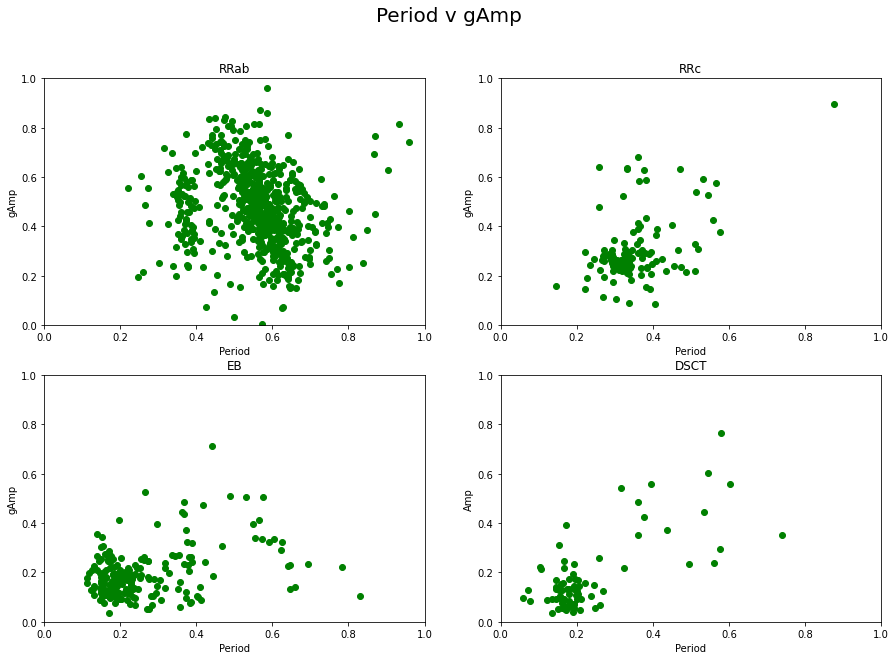

In [34]:
famp = 'gamp'
clr = 'g'
fig, ax = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Period v {}Amp'.format(famp[0]),fontsize=20)
ax[0,0].scatter(tabl[indsab]['period'],tabl[indsab][famp],c=clr)
ax[0,0].set_title('RRab')
ax[0,0].set_xlabel('Period')
ax[0,0].set_ylabel('{}Amp'.format(famp[0]))
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)
ax[0,1].scatter(tabl[indsc]['period'],tabl[indsc][famp],c=clr)
ax[0,1].set_title('RRc')
ax[0,1].set_xlabel('Period')
ax[0,1].set_ylabel('{}Amp'.format(famp[0]))
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(0,1)
ax[1,0].scatter(tabl[indseb]['period'],tabl[indseb][famp],c=clr)
ax[1,0].set_title('EB')
ax[1,0].set_xlabel('Period')
ax[1,0].set_ylabel('{}Amp'.format(famp[0]))
ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,1)
ax[1,1].scatter(tabl[inddsct]['period'],tabl[inddsct]['gamp'],c=clr)
ax[1,1].set_title('DSCT')
ax[1,1].set_xlabel('Period')
ax[1,1].set_ylabel('Amp'.format(famp[0]))
ax[1,1].set_xlim(0,1)
ax[1,1].set_ylim(0,1)

Text(0.5, 0, 'uAmp/rAmp')

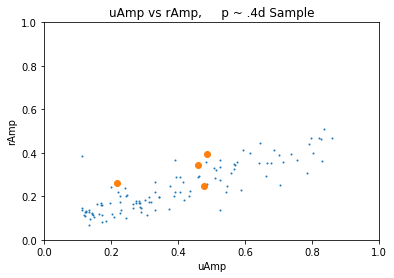

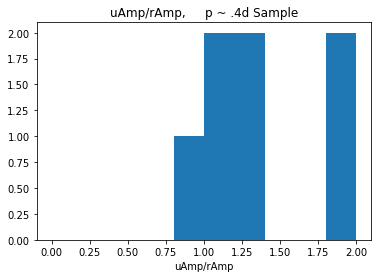

In [35]:
famp = 'uamp'
hamp = 'ramp'
ampsf = tabl[famp]
ampsh = tabl[hamp]

plt.figure()
plt.scatter(ampsf,ampsh,s=1,label='all')
plt.scatter(ampsf[cntr],ampsh[cntr],label='cntr')
plt.title('{}Amp vs {}Amp,     p ~ .4d Sample'.format(famp[0],hamp[0]))
plt.xlabel('{}Amp'.format(famp[0]))
plt.ylabel('{}Amp'.format(hamp[0]))
plt.xlim(0,1)
plt.ylim(0,1)

plt.figure()
plt.hist(ampsf[cntr]/ampsh[cntr],range=(0,2))
plt.title('{}Amp/{}Amp,     p ~ .4d Sample'.format(famp[0],hamp[0]))
plt.xlabel('{}Amp/{}Amp'.format(famp[0],hamp[0]))

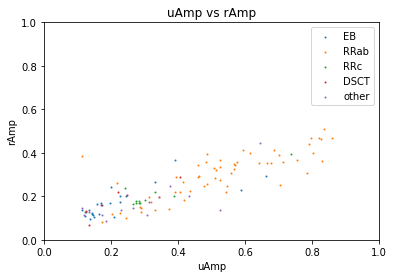

In [36]:
famp = 'uamp'
hamp = 'ramp'
ampsf = tabl[famp]
ampsh = tabl[hamp]
plt.scatter(ampsf[indseb],ampsh[indseb],s=1,label='EB')
plt.scatter(ampsf[indsab],ampsh[indsab],s=1,label='RRab')
plt.scatter(ampsf[indsc],ampsh[indsc],s=1,label='RRc')
plt.scatter(ampsf[inddsct],ampsh[inddsct],s=1,label='DSCT')
plt.scatter(ampsf[othr],ampsh[othr],s=1,label='other')
plt.xlim(0,1)
plt.ylim(0,1)
# plt.plot([0,1],[0,1],c='gray')
# plt.plot([0,1],[0,.668],c='gray')
plt.title('{}Amp vs {}Amp'.format(famp[0],hamp[0]))
plt.xlabel('{}Amp'.format(famp[0]))
plt.ylabel('{}Amp'.format(hamp[0]))
plt.legend()

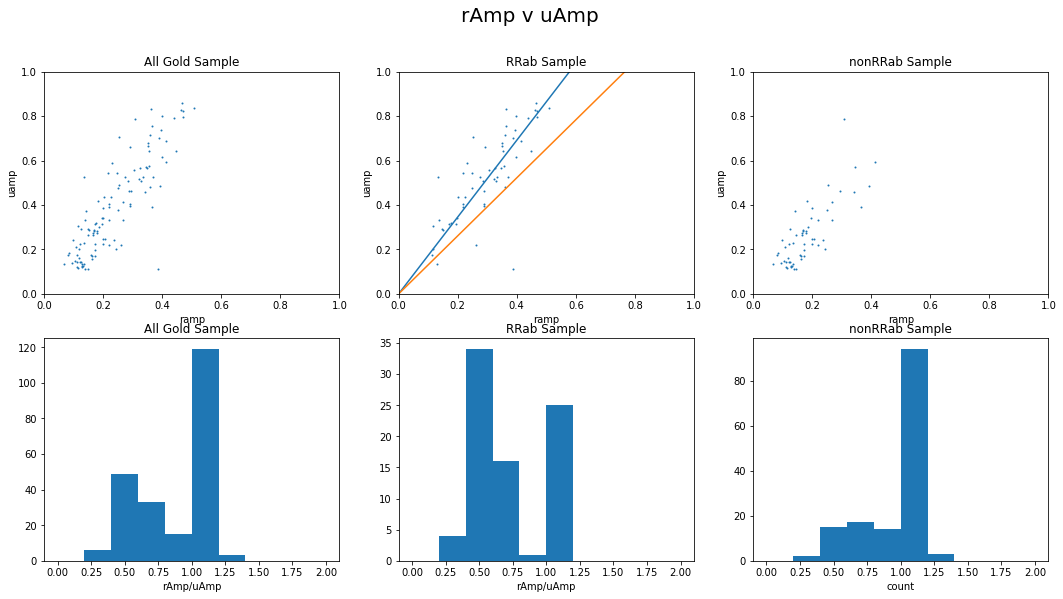

In [69]:
i=0
flts = ['u','g','r','i','z']
hamp = '{}amp'.format(flts[i])
famp = 'ramp'
ampsf = tabl[famp]
ampsh = tabl[hamp]
fig, ax = plt.subplots(2,3,figsize=(18,9))
fig.suptitle('{}Amp v {}Amp'.format(famp[0],hamp[0]),fontsize=20)

ax[0,0].scatter(ampsf,ampsh,s=1)
ax[0,0].set_xlim(0,1)
ax[0,0].set_ylim(0,1)
ax[0,0].set_title('All Gold Sample')
ax[0,0].set_xlabel(famp)
ax[0,0].set_ylabel(hamp)
ax[0,1].scatter(ampsf[indsrrab],ampsh[indsrrab],s=1)
ax[0,1].set_xlim(0,1)
ax[0,1].set_ylim(0,1)
ax[0,1].set_title('RRab Sample')
ax[0,1].set_xlabel(famp)
ax[0,1].set_ylabel(hamp)
ax[0,2].scatter(ampsf[indselse],ampsh[indselse],s=1)
ax[0,2].set_xlim(0,1)
ax[0,2].set_ylim(0,1)
ax[0,2].set_title('nonRRab Sample')
ax[0,2].set_xlabel(famp)
ax[0,2].set_ylabel(hamp)

ax[1,0].hist(ampsf[indsall]/ampsh[indsall],range=(0,2))
ax[1,0].set_title('All Gold Sample')
ax[1,0].set_xlabel('{}Amp/{}Amp'.format(famp[0],hamp[0]))
ax[1,1].hist(ampsf[indsrrab]/ampsh[indsrrab],range=(0,2))
ax[1,1].set_title('RRab Sample')
ax[1,1].set_xlabel('{}Amp/{}Amp'.format(famp[0],hamp[0]))
ax[1,2].hist(ampsf[indselse]/ampsh[indselse],range=(0,2))
ax[1,2].set_title('nonRRab Sample')
ax[1,2].set_xlabel('{}Amp/{}Amp'.format(famp[0],hamp[0]))
ax[1,2].set_xlabel('count')

newratios = [1.72727, 1.46138, 1.00000, 0.78905, 0.72697]
oldratios = [1.30498, 1.39378, 1.00000, 0.79186, 0.70998]

ax[0,1].plot([0,1],[0,newratios[i]])
ax[0,1].plot([0,1],[0,oldratios[i]])